In [1]:
%load_ext autoreload 
%autoreload 2

# TODO

- Take a unit cell
- Compute the supercell according to kmesh
- Choose a pair of atoms in the supercell
- Map their distance to [any (?)] periodic replica fulfilling the MIC
- Use mic_T as the argument of the Fourier Transform of $H_{ij\psi\phi}(k)$ to compute $H_{ij\psi\phi}(T)$
- Use the same mic_T to access the rascaline features computed in real space without PBCs

In [2]:
from ase.io import read
from ase.visualize import view
import numpy as np 
import torch 
import metatensor 
torch.set_default_dtype(torch.float64)

In [3]:
def check_target(coupled_blocks, tol=1e-4):
    """ Checks that the coupled blocks, when n1, l1 = n2, l2, satisfy 
            - block_type=1, lambda = ODD blocks are zero, 
            - block_type=-1, lambda = EVEN blocks are zero 
    """
    for k, b in coupled_blocks.items():
        btype= k['block_type']
        L = k['L']
        l1 = k['l_i']
        l2 = k['l_j']
        n1 = k['n_i']
        n2 = k['n_j']
        if L%2==0 and btype==-1 and (n1==n2) and (l1==l2):
            try:
                 assert torch.norm(b.values)<=tol, f'btype {btype} L{L} failed - Block norm {torch.norm(b.values)}'
            except AssertionError:
                failidx = torch.where(b.values>tol)[0]
                print(f'{k}, {torch.norm(b.values)} : {len(failidx)} failing samples - , {b.samples.values[failidx].tolist()}')#, values,{b.values[failidx]}' )

        elif L%2==1 and btype==1 and (n1==n2) and (l1==l2):
            try: 
                assert torch.norm(b.values)<=tol, f'btype {btype} L{L} failed - Block norm {torch.norm(b.values)}'
            except AssertionError:
                failidx = torch.where(b.values>tol)[0]
                print(f'{len(failidx)} failing samples, {b.samples.values[failidx]}')#, values,{b.values[failidx]}' )
  
                # print(f'try minus bytpe, {torch.norm(newb.values[failidx])}')

    print('TARGET PASSED')
def check_gij(gij, tol = 1e-4):
    """ Similar to the checks on the target above, we can check for gij that 
        - block_type = 1 < n| gij; lambda = ODD> = 0
        - block_type = -1 <n | gij; lambda = EVEN> = 0
    (inversion sigma = 1 for all of these blocks since they are directly the SPH components)
    """ 
    for k, b in gij.items(): 
        btype= k['block_type']
        L = k['spherical_harmonics_l']
        if L%2==0 and btype==-1 : 
            try:
                 assert torch.norm(b.values)<=tol, f'btype {btype} L{L} failed - Block norm {torch.norm(b.values)}'
            except AssertionError:
                failidx = torch.where(b.values>tol)[0]
                print(f'{k}, {torch.norm(b.values)} : {len(failidx)} failing samples - , {b.samples.values[failidx].tolist()}')
        elif L%2==1 and btype==1:
            try: 
                assert torch.norm(b.values)<=tol, f'btype {btype} L{L} failed - Block norm {torch.norm(b.values)}'
            except AssertionError:
                failidx = torch.where(b.values>tol)[0]
                print(f'{len(failidx)} failing samples, {b.samples.values[failidx]}')

    print('gij PASSED')

# Check that the Fourier Transform is invertible

In [4]:
from metatensor import Labels, TensorBlock, TensorMap
from mlelec.data.dataset import PySCFPeriodicDataset
from mlelec.utils.twocenter_utils import fix_orbital_order

/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [5]:
def fourier_transform(H_k, kpts, T):
    return 1/np.sqrt(np.shape(kpts)[0])*np.sum([np.exp(2j*np.pi * np.dot(ki, T)) * H_ki for ki, H_ki in zip(kpts, H_k)], axis = 0)
    
def inverse_fourier_transform(H_T, T_list, k):
    return 1/np.sqrt(np.shape(T_list)[0])*np.sum([np.exp(-2j*np.pi * np.dot(k, Ti)) * H_Ti for Ti, H_Ti in zip(T_list, H_T)], axis = 0)

In [6]:
from mlelec.utils.pbc_utils import scidx_from_unitcell
import warnings 
def get_T_from_pair(frame, supercell, i, j, dummy_T, kmesh):
                       
    assert np.all(np.sign(dummy_T) >= 0) or np.all(np.sign(dummy_T) <= 0), "The translation indices must either be all positive or all negative (or zero)"
    sign = np.sum(dummy_T)
    if sign != 0:
        sign = sign/np.abs(sign)
    dummy_T = np.abs(dummy_T)
    supercell = frame.repeat(kmesh)
    I = i
    J = scidx_from_unitcell(frame, j = j, T = dummy_T, kmesh = kmesh)
    d = supercell.get_distance(I, J, mic = True, vector = True) - frame.positions[j] + frame.positions[i]
    mic_T = np.int32(np.round(np.linalg.inv(frame.cell.array).T@d))
    # mic_T, _ = fix_translation_sign(frame, np.int32(sign*mic_T), j, I)
    return I, J, np.int32(sign*mic_T)

In [7]:
orbitals = {'sto-3g': {6: [[1,0,0],[2,0,0],[2,1,1], [2,1,-1],[2,1,0]]}, 
            'def2svp': {6: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]]}
           }

In [8]:
root = 'examples/data/periodic/graphene_supercell_variety'

names = ['hex'] #, 'hex22']
ORBS = 'sto-3g'
frames = read(f'{root}/graphene_variety.xyz', '1:2')

for frame in frames:
    frame.pbc = True

kmesh = [[8,8,1], [4,4,1]]
# kmesh = [[4,4,1]]
kfock = {name: np.transpose(np.load(f"{root}/fock_{name}22_{''.join(map(str, kmesh[i]))}.npy"), axes = (0, 2, 1)) for i, name in enumerate(names)}
kover = {name: np.load(f"{root}/over_{name}22_{''.join(map(str, kmesh[i]))}.npy") for i, name in enumerate(names)}

dataset = {name: PySCFPeriodicDataset(frames = [frames[i]], kgrid=kmesh[i], matrices_kpoint = kfock[name].reshape(1, *kfock[name].shape), 
                                      overlap_kpoint = kover[name].reshape(1, *kfock[name].shape), target=["real_translation"],
                                      device = "cpu", orbs = orbitals[ORBS], orbs_name = ORBS) for i,name in enumerate(names)}


# root = 'examples/data/periodic/c2/'
# names = ['hex']
# ORBS = 'sto-3g'
# START = 3
# STOP = 4

# frames = read(f'{root}/C2_174.extxyz', slice(START, STOP))
# fock_range = range(START,STOP)
# for frame in frames:
#     frame.pbc = True
#     frame.positions[[0,1]] = frame.positions[[1,0]]

# kmesh = [8,8,1]
# for f in frames:
#     f.pbc = [True, True, True]
# kfock = {name: np.array([np.load(f"examples/data/periodic/c2/fock_{ifock}_{''.join(map(str, kmesh))}.npy") 
#                          for ifock in fock_range]
#                        ) for name in names 
#         }
# kover = {name: np.array([np.load(f"examples/data/periodic/c2/over_{ifock}_{''.join(map(str, kmesh))}.npy") 
#                          for ifock in fock_range]
#                        ) for name in names 
#         }

# dataset ={name: PySCFPeriodicDataset(frames = frames, kgrid=kmesh, matrices_kpoint = kfock[name], overlap_kpoint=kover[name], 
#                                      target=["real_translation"] ,device = "cpu", orbs = orbitals[ORBS]) for name in names}

In [9]:
name = 'hex'
# assert np.linalg.norm(kfock[name] - np.transpose(kfock[name], (0,2,1)).conj()) # Hk is hermitian
# assert np.linalg.norm(kfock[name][0] - np.transpose(kfock[name][0], (0,2,1)).conj()) # Hk is hermitian
frame = dataset[name].structures[0].copy()
kmesh = dataset[name].kmesh[0]

In [10]:
supercell = frame.repeat(kmesh)
kpts = dataset[name].cells[0].get_scaled_kpts(dataset[name].cells[0].make_kpts(kmesh))
H_k = dataset[name].matrices_kpoint[0]

### Dictionary structure

In [11]:
counter_T = {}
natm = frame.get_global_number_of_atoms()
nao = 5
for dummy_T in dataset[name].desired_shifts:
    for i in range(frame.get_global_number_of_atoms()):
        for j in range(frame.get_global_number_of_atoms()):
            I, J, mic_T = get_T_from_pair(frame, supercell, i, j, dummy_T, kmesh)
            mic_T = tuple(mic_T)
            if mic_T not in counter_T:
                counter_T[mic_T] = np.zeros((natm, natm))
            counter_T[mic_T][i,j] += 1

In [12]:
T_dict = {}
full_T_list = list(counter_T.keys())
i0 = 0
i_skip = 0
for i in range(len(full_T_list)):
    
    if i < i0 + i_skip:
        continue
    
    summa = 0
    counter_list = []
    T_list = []
    i_skip = 0
    while summa != natm**2:
        counter_list.append(counter_T[full_T_list[i+i_skip]])
        T_list.append(full_T_list[i+i_skip])
        summa = np.sum(counter_list)
        i_skip += 1
    i0 = i
    T_dict[full_T_list[i]] = T_list

In [13]:
H_T_fix = {}
H_minus_T_fix = {}

nao = 5
natm = frame.get_global_number_of_atoms()

for T_dummy in T_dict:
    H_T_fix[T_dummy] = np.zeros((natm*nao, natm*nao), dtype = np.complex128)
    H_minus_T_fix[T_dummy] = np.zeros((natm*nao, natm*nao), dtype = np.complex128)
    for T in T_dict[T_dummy]:
        pairs = np.where(counter_T[T])
        for i, j in zip(*pairs):
            H_T_fix[T_dummy][nao*i:nao*(i+1), nao*j:nao*(j+1)] = fourier_transform(H_k, kpts, T)[nao*i:nao*(i+1), nao*j:nao*(j+1)]
            H_minus_T_fix[T_dummy][nao*j:nao*(j+1), nao*i:nao*(i+1)] = fourier_transform(H_k, kpts, -np.array(T))[nao*j:nao*(j+1), nao*i:nao*(i+1)]            
            
for mic_T in H_T_fix:
    assert np.allclose(H_T_fix[mic_T], H_T_fix[mic_T].real), np.allclose(H_T_fix[mic_T], H_T_fix[mic_T].real)
    H_T_fix[mic_T] = torch.from_numpy(H_T_fix[mic_T].real)
    assert np.allclose(H_minus_T_fix[mic_T], H_minus_T_fix[mic_T].real), np.allclose(H_minus_T_fix[mic_T], H_minus_T_fix[mic_T].real)
    H_minus_T_fix[mic_T] = torch.from_numpy(H_minus_T_fix[mic_T].real)

In [14]:
# ASSERT H(T) = H(-T)\dagger
for T in H_T_fix:
    # print(H_T_fix[T].shape, H_minus_T_fix[T].shape)
    assert np.isclose(torch.norm(H_T_fix[T]-H_minus_T_fix[T].T).item(), 0), (T, torch.norm(H_T_fix[T]-H_minus_T_fix[T].T).item())

In [15]:
reconstructed_H_k = []
for k in kpts:
    reconstructed_H_k.append(inverse_fourier_transform(np.array(list(H_T_fix.values())), np.array(list(H_T_fix.keys())), k))
    # reconstructed_H_k.append(inverse_fourier_transform(np.array(list(H_minus_T_fix.values())), -np.array(list(H_minus_T_fix.keys())), k))
    
    # reconstructed_H_k.append(inverse_fourier_transform(np.array(list(H_Tvalues())), np.array(list(H_T.keys())), k))
reconstructed_H_k = torch.from_numpy(np.array(reconstructed_H_k))
assert reconstructed_H_k.shape == H_k.shape

In [16]:
print(torch.norm(reconstructed_H_k-H_k))

tensor(7.6990e-12)


In [17]:
# SET matrices translation of the dataset 

# REMEMBER TO fix orbital order 
for name in ['hex']: 
    for ifr in range(len(dataset[name].structures)):
        # MUST BE A BETTER WAY TO DO THIS!
        for T in H_T_fix:
        # for T in dataset[name].matrices_translation[ifr]: 
            # dataset[name].matrices_translation[ifr][T] = fix_orbital_order(dataset[name].matrices_translation[ifr][T], dataset[name].structures[ifr], dataset[name].basis)
            H_T_fix[T] = fix_orbital_order(H_T_fix[T], dataset[name].structures[ifr], dataset[name].basis) # DONT FORGET to symm the matrix to symm
            H_minus_T_fix[T] = fix_orbital_order(H_minus_T_fix[T], dataset[name].structures[ifr], dataset[name].basis) # DONT FORGET to symm the matrix to symm

dataset[name].set_matrices_translation([H_T_fix])

# Compute targets

In [18]:
from metatensor import load 
from mlelec.utils.twocenter_utils import _to_coupled_basis
from mlelec.utils.pbc_utils import matrix_to_blocks 

def get_targets(dataset, negative_shift_matrices, device ="cpu"):
    blocks = matrix_to_blocks(dataset, negative_shift_matrices, device = 'cpu')
    coupled_blocks = _to_coupled_basis(blocks, skip_symmetry = True, device = device, translations = True)
    

    blocks = blocks.keys_to_samples('cell_shift_a')
    blocks = blocks.keys_to_samples('cell_shift_b')
    blocks = blocks.keys_to_samples('cell_shift_c')

    coupled_blocks = coupled_blocks.keys_to_samples('cell_shift_a')
    coupled_blocks = coupled_blocks.keys_to_samples('cell_shift_b')
    coupled_blocks = coupled_blocks.keys_to_samples('cell_shift_c')
    return blocks , coupled_blocks

In [19]:
target_blocks = {name: get_targets(dataset[name], [H_minus_T_fix])[0] for name in ['hex']}
target_coupled_blocks = {name: get_targets(dataset[name], [H_minus_T_fix])[1] for name in ['hex']}

# MUST PASS 
check_target(target_coupled_blocks[name])

TARGET PASSED


In [20]:
# nb = 21
# print(target_coupled_blocks['hex'].keys[nb])
# print(target_coupled_blocks['hex'][nb].samples.values[95])
# print(target_coupled_blocks['hex'][nb].values[95])
# print(target_coupled_blocks['hex'][nb].samples.values[159])
# print(target_coupled_blocks['hex'][nb].values[159])

# nb = 22
# print(target_coupled_blocks['hex'].keys[nb])
# print(target_coupled_blocks['hex'][nb].samples.values[95])
# print(target_coupled_blocks['hex'][nb].values[95])
# print(target_coupled_blocks['hex'][nb].samples.values[159])
# print(target_coupled_blocks['hex'][nb].values[159])

# nb = 25
# print(target_coupled_blocks['hex'].keys[nb])
# print(target_coupled_blocks['hex'][nb].samples.values[95])
# print(target_coupled_blocks['hex'][nb].values[95])
# print(target_coupled_blocks['hex'][nb].samples.values[159])
# print(target_coupled_blocks['hex'][nb].values[159])

# nb = 26
# print(target_coupled_blocks['hex'].keys[nb])
# print(target_coupled_blocks['hex'][nb].samples.values[95])
# print(target_coupled_blocks['hex'][nb].values[95])
# print(target_coupled_blocks['hex'][nb].samples.values[159])
# print(target_coupled_blocks['hex'][nb].values[159])

In [36]:
# for k, b in target_coupled_blocks[name].items():
#     print(k, torch.norm(b.values))

In [37]:
for T in H_T_fix:
    if tuple(np.int32(-np.array(T))) not in H_T_fix:
        print(T, 'no')
    # else:
        # print(T, 'yes')

(0, 2, 0) no
(2, 0, 0) no
(-2, 2, 0) no


In [38]:
np.unique(np.array(target_coupled_blocks['hex'][12].samples.view(['cell_shift_a','cell_shift_b','cell_shift_c']).values.tolist()),axis=0).shape

(16, 3)

## Reconstruct H_T, H_T_minus from the blocks 

In [39]:
from mlelec.utils.twocenter_utils import _to_matrix, _to_uncoupled_basis
from mlelec.utils.pbc_utils import blocks_to_matrix
predblocks = target_coupled_blocks['hex']
predblocks_un = _to_uncoupled_basis(predblocks)
recon_blocks = {}
tblocks = []
tblock_keys = []
for translation in dataset['hex'].desired_shifts[0]:
    block_keys = []
    blocks = []
    for key, block in predblocks_un.items():
            # TODO: replace labels_where
            # try:
            if True:
                lbl =Labels(
                        ["cell_shift_a", "cell_shift_b", "cell_shift_c"],
                        values=np.asarray(
                            [translation[0], translation[1], translation[2]]
                        ).reshape(1, -1),
                    )
                xx = block.samples.view(["cell_shift_a", "cell_shift_b", "cell_shift_c"]).values
                idx = np.where(np.all(np.isclose(np.array(xx),np.array([translation[0], translation[1], translation[2]])), 
                                      axis = 1))[0]


            # except:
            #     print("{} not found in {}".format(translation, key))
            #     continue

            if len(idx):
                tblock_keys.append(list(key.values)+[translation[0], translation[1], translation[2]])
    
                tblocks.append( TensorBlock(
                        samples=Labels(
                            predblocks.sample_names[:-3],
                            values=np.asarray(block.samples.values[idx])[:, :-3],
                        ),
                        values=block.values[idx],
                        components=block.components,
                        properties=block.properties,
                    ))
                

tmap = TensorMap(Labels(predblocks_un.keys.names+["cell_shift_a", "cell_shift_b", "cell_shift_c"],np.asarray(tblock_keys)), tblocks)
predfocks, predfocks_m = blocks_to_matrix(tmap, dataset['hex'])


In [26]:
# for T in predfocks[0]: 
#     for i in range(2):
#         for j in range(2):
#             m1 = predfocks[0][T].clone()[i*5:(i+1)*5, j*5:(j+1)*5]
#             m2 = dataset['hex'].matrices_translation[0][T].clone()[i*5:(i+1)*5, j*5:(j+1)*5]
#             mask = torch.abs(m2)<1e-11
#             m2[mask]=0
#             m1[mask]=1
#             for row in m2/m1:
#                 for v in row:
#                     print(f'{v:>15.5f}', end = ' ')
#                 print()

In [27]:
# tmap = tmap.keys_to_samples('cell_shift_a')
# tmap = tmap.keys_to_samples('cell_shift_b')
# tmap = tmap.keys_to_samples('cell_shift_c')
# for k, b in target_blocks['hex'].items():
    # print(torch.linalg.norm(tmap.block(k).values - b.values))

In [ ]:
# Error on reconstructed fock matrices from blocks 
i=1
j=0
for T in predfocks[0]:
    # idx1=slice(i*5,(i+1)*5)
    # idx2=slice(j*5,(j+1)*5)
    sum1 = predfocks[0][T]#[idx1, idx2]# + predfocks_m[T][0][idx2, idx1]
    sum2 = dataset[name].matrices_translation[0][T]#[idx1, idx2] #+ H_minus_T_fix[T][idx2, idx1]
    try: 
        assert torch.norm(sum1 - sum2)<1e-10
    except AssertionError: 
        print(T, torch.norm(sum1 - sum2), torch.norm(sum1), torch.norm(sum2)) #, torch.norm(predfocks[T][0][idx1, idx2]), torch(predfocks_m[T][0][idx2, idx1]), H_minus_T_fix[T][idx2, idx1], )

# Features

In [21]:
from mlelec.features.acdc import pair_features, single_center_features, twocenter_features_periodic_NH

def get_pair_features(frames, hypers_atoms, hypers_pair, order_nu, all_pairs, both_centers, max_shift,  desired_shifts, mic, kmesh, device, lcut,return_rho0ij,counter,T_dict):
    return pair_features(frames, hypers_atoms, hypers_pair, order_nu=order_nu, all_pairs=all_pairs, both_centers=both_centers, max_shift=max_shift,
            desired_shifts=desired_shifts, mic=mic, kmesh=kmesh, device=device, lcut=lcut,return_rho0ij=return_rho0ij, counter = counter, T_dict = T_dict)

def rascaline_gij(dataset):
    from mlelec.features.acdc_utils import fix_gij, acdc_standardize_keys
    hypers_pair = {'cutoff': 12,
            'max_radial':10,
            'max_angular':4,
            'atomic_gaussian_width':0.6,
            'center_atom_weight':1,
            "radial_basis": {"Gto": {}},
            "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
    }
    from rascaline import SphericalExpansionByPair 
    calculator = SphericalExpansionByPair(**hypers_pair)
    gij= calculator.compute(dataset.structures)
    gij = fix_gij(gij)
    gij = acdc_standardize_keys(gij)
    return gij

def compute_features(dataset, counter = None, T_dict = None, return_rho0ij = False, both_centers=True):
# +
    hypers_pair = {'cutoff': 4,
            'max_radial':10,
            'max_angular':4,
            'atomic_gaussian_width':0.6,
            'center_atom_weight':1,
            "radial_basis": {"Gto": {}},
            "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
    }

    hypers_atom = {'cutoff': 4,
            'max_radial':10,
            'max_angular':4,
            'atomic_gaussian_width':0.3,
            'center_atom_weight':1,
            "radial_basis": {"Gto": {}},
            "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
    }
    device = "cpu"
    # -

    LCUT = 3 #2*np.max([np.max( np.asarray(orbitals[ORBS][k])[:,1]) for k in orbitals[ORBS]])
    print("LCUT", LCUT)

    if both_centers and not return_rho0ij:
        NU = 3
    else:
        NU = 2

    print(return_rho0ij)

    rhoij = get_pair_features(dataset.structures, hypers_atom, hypers_pair, order_nu = 1, all_pairs = True, both_centers = both_centers,
                                max_shift = dataset.kmesh[0] ,  desired_shifts = dataset.desired_shifts, mic = True,
                                kmesh = dataset.kmesh[0], device="cpu", lcut = LCUT, return_rho0ij = return_rho0ij, counter = counter, T_dict = T_dict)

    print('rhoij computed')
    if return_rho0ij:
        # return rhoij
        NU = 1 
    rhonui = single_center_features(dataset.structures, hypers_atom, order_nu = NU, lcut=LCUT, device = device,
                                    feature_names = rhoij.property_names)
    # save('rhonui', rhonui, use_numpy = True)
    # print("rhonui saved", flush = True)
    return rhonui, rhoij

def compute_hfeat(rhonui, rhoij):
    hfeat = twocenter_features_periodic_NH(single_center=rhonui, pair= rhoij)
    return hfeat

In [22]:
# CHECK GIJ 
return_gij = True
both_centers = True
rhonui, rhoij = compute_features(dataset[name], return_rho0ij=return_gij, counter = [counter_T], T_dict = [T_dict], both_centers = both_centers)
hfeat = compute_hfeat(rhonui, rhoij)
check_gij(hfeat)


LCUT 3
True
hypers_pair {'cutoff': 12.0, 'max_radial': 10, 'max_angular': 4, 'atomic_gaussian_width': 0.6, 'center_atom_weight': 1, 'radial_basis': {'Gto': {}}, 'cutoff_function': {'ShiftedCosine': {'width': 0.1}}}


/home/pegolo/Software/my_mlelec/src/mlelec/features/acdc.py:145: UserWarning: Using cutoff 12.0 for all pairs feature
  warnings.warn(
/home/pegolo/Software/my_mlelec/src/mlelec/features/acdc.py:167: UserWarning: Using kmesh [4, 4, 1] for MIC mapping
  warnings.warn(f"Using kmesh {kmesh} for MIC mapping")


rhoij computed
3
l 0
k [1 1 0 6 6]
values tensor(0.) tensor(0.) tensor(7.7697) tensor(3.8849) tensor(3.8849) stupid tensor([], dtype=torch.int64)
3
l 1
k [1 1 1 6 6]
values tensor(0.) tensor(12.4903) tensor(0.) tensor(6.2451) tensor(6.2451) stupid tensor([], dtype=torch.int64)
3
l 2
k [1 1 2 6 6]
values tensor(0.) tensor(0.) tensor(14.4789) tensor(7.2394) tensor(7.2394) stupid tensor([], dtype=torch.int64)
3
l 3
k [1 1 3 6 6]
values tensor(0.) tensor(15.3405) tensor(0.) tensor(7.6702) tensor(7.6702) stupid tensor([], dtype=torch.int64)
3
l 4
k [1 1 4 6 6]
values tensor(0.) tensor(0.) tensor(15.6820) tensor(7.8410) tensor(7.8410) stupid tensor([], dtype=torch.int64)
gij PASSED


In [23]:
return_gij = False
both_centers = True
rhonui, rhoij = compute_features(dataset[name], return_rho0ij=return_gij, counter = [counter_T], T_dict=[T_dict], both_centers = both_centers)
hfeat = compute_hfeat(rhonui, rhoij)

LCUT 3
False
hypers_pair {'cutoff': 12.0, 'max_radial': 10, 'max_angular': 4, 'atomic_gaussian_width': 0.6, 'center_atom_weight': 1, 'radial_basis': {'Gto': {}}, 'cutoff_function': {'ShiftedCosine': {'width': 0.1}}}


/home/pegolo/Software/my_mlelec/src/mlelec/features/acdc.py:269: UserWarning: nu_j not defined, using nu_i for nu_j as well
  warnings.warn("nu_j not defined, using nu_i for nu_j as well")


rhoij computed
3
l 0
k [3 1 0 6 6]
values tensor(6.6019) tensor(6.6019) tensor(25.9454) tensor(13.3861) tensor(13.3861) stupid tensor([   0,    2,    5,    9,   12,   13,   31,   32,   33,   34,   35,   36,
          41,   42,   43,   44,   45,   46,   63,   64,   65,   67,   68,   69,
          71,   72,   73,   74,   76,   77,   96,   97,   99,  100,  102,  103,
         104,  106,  107,  108,  109,  110,  143,  145,  148,  152,  155,  156,
         174,  175,  176,  177,  178,  179,  184,  185,  186,  187,  188,  189,
         206,  207,  208,  210,  211,  212,  214,  215,  216,  217,  219,  220,
         239,  240,  242,  243,  245,  246,  247,  249,  250,  251,  252,  253,
         254,  255,  256,  257,  258,  259,  264,  265,  266,  267,  268,  269,
         286,  288,  291,  295,  298,  299,  317,  319,  320,  322,  323,  325,
         326,  327,  329,  330,  331,  332,  349,  350,  351,  353,  354,  355,
         357,  358,  359,  360,  362,  363,  397,  398,  399,  400,  401,

In [ ]:
# Missing keys in targets vs feats
# flabel=Labels(hfeat.sample_names[:-1], hfeat[12].samples.values[:,:-1])
# first = target_coupled_blocks['hex'][12].samples
# intersection, mapping_1, mapping_2 = first.intersection_and_mapping(flabel)
# print(flabel.values[mapping_2==-1])

In [ ]:
for k, b in hfeat.items():
    print(k, torch.norm(b.values))

In [24]:
from mlelec.models.linear import LinearModelPeriodic
device='cpu'

In [25]:
def train_ridge(model, target_blocks, set_bias=False):
    block_losses = {}
    loss = 0
    pred, ridges, kernels = model.fit_ridge_analytical(return_matrix = False, set_bias = set_bias)

    for (key, block) in pred.items():
        block_loss=torch.norm(block.values - target_blocks[key].values)**2
        loss += block_loss
        
        block_losses[tuple(key.values)] = block_loss

    # print(np.sum(list(block_losses.values())))
    return loss, pred, ridges, block_losses#, kernels 

In [26]:
model_ridge = LinearModelPeriodic(twocfeat=hfeat, target_blocks=target_coupled_blocks['hex'], frames = dataset['hex'].structures, orbitals= dataset['hex'].basis, 
                                  cell_shifts=dataset['hex'].desired_shifts[:], device = device)

In [27]:
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, target_coupled_blocks['hex'], set_bias = True)
print(loss_ridge_bias)

tensor(9.0044e-07)


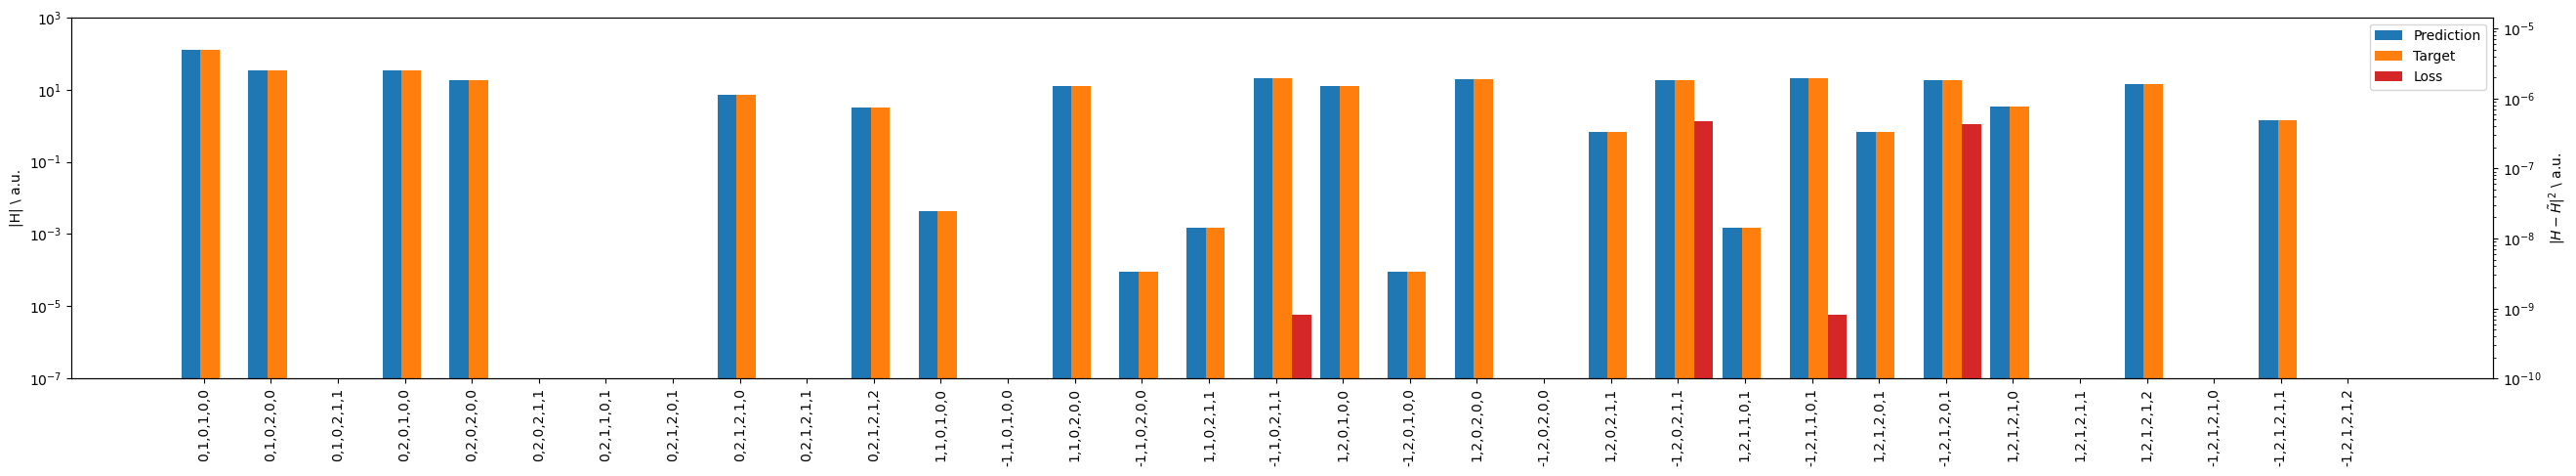

In [28]:
from mlelec.utils.plot_utils import plot_block_errors
plot_block_errors(pred_ridge_bias, target_coupled_blocks['hex'], plot_loss=True)

In [29]:
plot_block_errors??

Signature: plot_block_errors(target_blocks, pred_blocks, plot_loss=False)
Docstring: <no docstring>
Source:   
def plot_block_errors(target_blocks, pred_blocks, plot_loss=False):
    try:
        # coupled block
        x = [
            ",".join([str(lbl[i]) for i in [0, 2, 3, 5, 6, 7]])
            for lbl in target_blocks.keys.values.tolist()
        ]
    except:
        # uncouoled block
        x = [
            ",".join([str(lbl[i]) for i in [0, 2, 3, 5, 6]])
            for lbl in target_blocks.keys()
        ]
    fs = plt.rcParams["figure.figsize"]
    fig, ax = plt.subplots(figsize=(fs[0] * 5, fs[1]))
    ax_loss = ax.twinx()
    # s = (0,0,0)
    prediction_ = np.array([torch.linalg.norm(b.values).item() for b in pred_blocks])
    target_ = np.array([torch.linalg.norm(b.values).item() for b in target_blocks])
    loss_ = np.array(
        [
            (torch.linalg.norm(b.values - b1.values) ** 2).item()
            for b, b1 in zip(target_blocks, pred_blocks)
        ]
  

In [34]:
sample_losses = {}
idx_losses = {}
for kt, bt in target_coupled_blocks['hex'].items():

    bp = pred_ridge_bias.block(kt) # find pred block for key
    block_loss = loss_blocks[tuple(kt.values)]
    # print(kt.values, block_loss)
    if block_loss> 1e-8: 
        sample_loss = torch.norm((bp.values - bt.values), dim=(1,2))
        sample_losses[tuple(kt)] = sample_loss
        idx_losses[tuple(kt)] = torch.where(sample_loss>1e-1)
        assert torch.isclose(sum(torch.pow(sample_loss,2) ), block_loss), (sum(sample_loss**2 ), block_loss)
        print(kt.values, torch.max(sample_loss), sample_loss.shape, block_loss, torch.sum(torch.pow(sample_loss,2)))#torch.where(sample_norm>1e-5))

[-1  6  2  0  6  2  1  1] tensor(6.3006e-05) torch.Size([1016]) tensor(4.6951e-07) tensor(4.6951e-07)
[-1  6  2  1  6  2  0  1] tensor(6.2840e-05) torch.Size([1016]) tensor(4.2928e-07) tensor(4.2928e-07)


(0.0, 300.0)

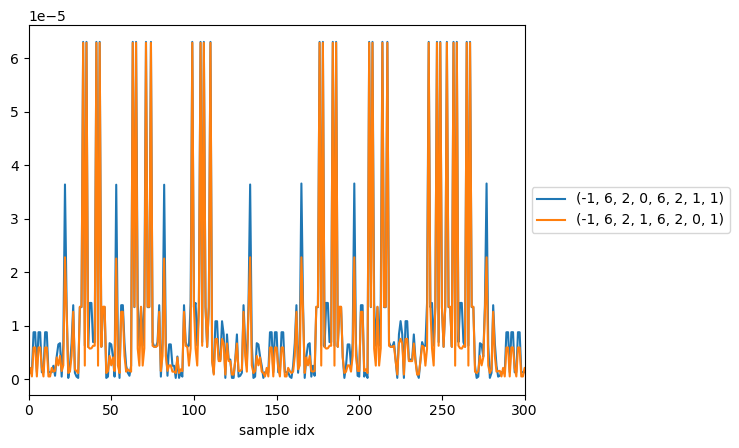

In [39]:
import matplotlib.pyplot as plt
for k, sample_loss in sample_losses.items():
    plt.plot(sample_loss, label = k)
plt.legend(loc = 'center left', bbox_to_anchor = (1,0.5))
plt.xlabel('sample idx')
plt.xlim(0,300)
# plt.plot(sample_loss)

In [ ]:
stupid_idx =[78,  79,  87,  88,  93,  94,  95,  96, 102, 103, 104, 151, 152, 153,
          158, 159, 160, 161, 167, 168, 175, 176]

FEAT_KEYIDX = 8
print(hfeat.keys[FEAT_KEYIDX])
print(hfeat[FEAT_KEYIDX].samples.values[stupid_idx]) 
# print(torch.norm(hfeat[FEAT_KEYIDX].values[stupid_idx][0]-hfeat[FEAT_KEYIDX].values[stupid_idx][0]))
print(torch.norm(hfeat[FEAT_KEYIDX].values[stupid_idx][0]-hfeat[FEAT_KEYIDX].values[stupid_idx][2]))


In [ ]:
fig, ax = plt.subplots()
ax.set_aspect('equal')

for _, i, j, Tx, Ty, _, _ in hfeat[9].samples.values[stupid_idx][:9]:
    ini = frame.positions[i]
    fin = frame.cell.array.T@np.array([Tx, Ty, 0]) + frame.positions[j]
    print(np.linalg.norm(fin-ini))
    ax.plot([ini[0], fin[0]], [ini[1], fin[1]], lw = 2, label = f'{np.linalg.norm(fin-ini):.3f}')
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()

atom_colors = {0: 'red', 1: 'lime'}
for Tx in range(-3,3):
    for Ty in range(-3, 3):
        for i in range(2):
            x, y = (frame.cell.array.T@np.array([Tx, Ty, 0]) + frame.positions[i])[:2]
            ax.plot([x], [y], 'o', markersize = 12, color = atom_colors[i])
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))

In [ ]:
gij = rascaline_gij(dataset['hex'])
gij_labels = []
gij_labels_pos = []
for lbl in hfeat[9].samples.values[stupid_idx]:
    gij_lbl = Labels(hfeat.sample_names[:-1], np.array([list(lbl)[:-1]]))[0]
    gij_labels.append(gij_lbl)
    gij_labels_pos.append(gij[0].samples.position(gij_lbl))
print(gij[0].values[gij_labels_pos])


In [ ]:
a=1.42
from ase import Atoms
import pyscf.pbc.gto as pbcgto
import pyscf.pbc.tools.pyscf_ase as pyscf_ase

graphene = Atoms(symbols=['C','C'], cell=a/2*np.array([[3,-np.sqrt(3),0],[3,np.sqrt(3),0],[0,0,20]]), scaled_positions=[[1/3,1/3,0],[2/3,2/3,0]], pbc=[True,True,False])
cell = pbcgto.Cell()
cell.atom = pyscf_ase.ase_atoms_to_pyscf(graphene)
cell.basis = 'sto-3g'
cell.a = graphene.cell
cell.verbose = 0
cell.precision=1e-8
cell.dimension=2
cell.build()

In [ ]:
cell.atom_coord(0)

In [ ]:
graphene.positions/0.529177

In [ ]:
# T1 = -2,0,0
# T2 = -2,1,0
T1 = 0,0,0
T2 = 1,0,0
# T1 = -3,0,0
# T2 = -3,1,0
i = 0
j = 1 
Hij = {}
Hmij = {}
for T in [T1, T2]:
    H = H_T_fix[T]
    Hm = H_minus_T_fix[T]
    idx_i = slice(i*5,(i+1)*5)
    idx_j = slice(j*5,(j+1)*5)
    
    
    Hij[T] = H[idx_i, idx_j]
    Hmij[T] = Hm[idx_j, idx_i]
    
    # print(Hij)
    # print(Hmij)

In [ ]:
fij = {}
fji = {} 
for T in [T1, T2]:
    fij_lbl = Labels(rhoij.sample_names, np.array([[0,i,j, *T,1]]))
    fji_lbl = Labels(rhoij.sample_names, np.array([[0,j,i, *T,-1]]))
    fij_idx = rhoij[0].samples.position(fij_lbl[0])
    fji_idx = rhoij[0].samples.position(fji_lbl[0])
    fij[T] = rhoij[0].values[fij_idx]
    fji[T] = rhoij[0].values[fji_idx]
#     print(fij)
#     print(fji)
# print('diff', torch.norm(fij - fji))
# print('sum', torch.norm(fij + fji))

In [ ]:
# print(Hij[T1] - Hij[T2])
# print(Hmij[T1] - Hmij[T2])
# print(fij[T1] - fij[T2])
# print(fji[T1] - fji[T2])

def print_matrix(matrix):
    for row in matrix:
        for v in row:
            print(f'{v:>12.2e}', end = ' ')
        print()

for T in [T1, T2]:
    print(T)
    print('-')
    print_matrix(Hij[T] - Hmij[T])
    print('F', fij[T] - fji[T])
    print('\n+')
    print_matrix(Hij[T] + Hmij[T])
    print('F', fij[T] + fji[T])
# print(Hmij[T1] - Hmij[T2])
# print(fij[T1] - fij[T2])
# print(fji[T1] - fji[T2])


In [ ]:
for T in [T1, T2]:
    print(T)
    # print('-')
    print_matrix(Hij[T])
    print(fij[T])
    print()
    # print('\n+')
    # print_matrix(Hij[T] + Hmij[T])
    # print(fij[T] + fji[T])

In [ ]:
TARGET_KEYIDX = 12
print(target_coupled_blocks['hex'].keys[TARGET_KEYIDX])
target_labels = []
target_labels_pos = []
for lbl in hfeat[FEAT_KEYIDX].samples.values[stupid_idx]:
    tar_lbl = Labels(hfeat.sample_names[:-1], np.array([list(lbl)[:-1]]))[0]
    target_labels.append(tar_lbl)
    target_labels_pos.append(target_coupled_blocks['hex'][TARGET_KEYIDX].samples.position(tar_lbl))


In [ ]:

target_coupled_blocks['hex'][TARGET_KEYIDX].values[target_labels_pos]


In [ ]:
print(gij[1].values[gij_labels_pos])


In [ ]:
gij[0]

# BEGIN

## predict with ridge models

In [ ]:

def rascaline_gij(dataset):
    hypers_pair = {'cutoff': 12,
            'max_radial':10,
            'max_angular':4,
            'atomic_gaussian_width':0.6,
            'center_atom_weight':1,
            "radial_basis": {"Gto": {}},
            "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
    }
    from rascaline import SphericalExpansionByPair 
    calculator = SphericalExpansionByPair(**hypers_pair)
    return calculator.compute(dataset.structures)



In [ ]:
# view(dataset['hex'].structures)
return_gij = True
rhonui, rhoij = compute_features(dataset[name], return_rho0ij=return_gij, counter = [counter_T], where_Ts_allowed=where_Ts_allowed)
hfeat = compute_hfeat(rhonui, rhoij)

## to debug: 


In [ ]:

I = 0 
J = 1
for k,b in rhoij.items():
    L = k['spherical_harmonics_l']
    
    for Tx, Ty, Tz in T_keys:
        sample_label_ij = Labels(
                        b.samples.names,
                        np.array([[0, I, J, Tx, Ty, Tz, 1,]]))
        
        sample_label_ji = Labels(
                        b.samples.names,
                        np.array([[0, J, I, Tx, Ty, Tz, -1]])
        )
        pos_ij = np.where(np.all(b.samples.values == sample_label_ij.values, axis=1))[0]
        
                    # pos_ij = b.samples.position(sample_label_ij[0])
        pos_ji = np.where(np.all(b.samples.values == sample_label_ji.values, axis=1))[0]
    
        try: 
            assert torch.norm(b.values[pos_ij] - (-1)**L * b.values[pos_ji])<=1e-6
        except AssertionError:
            print(k, pos_ij, pos_ji)

In [ ]:
b.values[pos_ij]

In [ ]:
b.values[pos_ji]

In [ ]:
gij = rascaline_gij(dataset['hex'])

In [ ]:
for k,b in gij.items():
    print(np.linalg.norm(b.values))

In [ ]:
b = gij[1]
sample_label_ij = Labels(
                b.samples.names,
                np.array([[0, 0, 1, 1, -1, 0]])
)
sample_label_ji = Labels(
                b.samples.names,
                np.array([[0, 1, 0, -1, 1, 0]])
)
pos_ij = np.where(np.all(b.samples.values[:, :6] == sample_label_ij.values[:, :6], axis=1))[0]

            # pos_ij = b.samples.position(sample_label_ij[0])
pos_ji = np.where(np.all(b.samples.values[:, :6] == sample_label_ji.values[:, :6], axis=1))[0]

                                  
print(pos_ij, pos_ji)

In [ ]:
b.values[pos_ij] 

In [ ]:
b.values[pos_ji]

In [ ]:
i = 0; j=1; T = [1,-1,0]
frame = dataset['hex'].structures[0]
cell = frame.cell.array.T
d = cell@T + frame.positions[j] - frame.positions[i]
print(d)

In [ ]:
d = cell@T + frame.positions[i] - frame.positions[j]
print(d)

In [ ]:
block_type = 1
L = 1
inversion_sigma = 1

b = hfeat.block(block_type=block_type, spherical_harmonics_l=L, inversion_sigma=inversion_sigma)#.values
mb  = hfeat.block(block_type=-1*block_type, spherical_harmonics_l=L, inversion_sigma=inversion_sigma)#.values

In [ ]:
torch.norm(b.values), torch.norm(mb.values)

In [ ]:
TOL = 1e-5
for k,b in hfeat.items():
    L = k['spherical_harmonics_l']
    if k['block_type']==1 or k['block_type']==-1:
        # print(k.values, np.array([-1*k['block_type']]+k.values[1:].tolist() ]))
        mkey = Labels(k.names, np.array([k.values[:-1].tolist() +[-1*k['block_type']] ]))
        mb = hfeat.block(mkey)
        assert b.samples == mb.samples
        
        # print(L, k['block_type'], torch.norm(b.values - (-1)**L * mb.values)  )# mb.values))
        
        if (L%2 == 1 and k['block_type'] == 1) or (L%2 == 0 and k['block_type'] == -1):
            assert torch.norm(b.values) <=TOL, (L, k, torch.norm(b.values), '+' )
        elif (L%2 == 1 and k['block_type'] == -1) or (L%2 == 0 and k['block_type'] == 1): 
            assert torch.norm(mb.values) <=TOL, (L, k, torch.norm(mb.values), '-' )
        else:
            print('s<ah,jfbvaekugdfsuiyhg')
print('PASS')

In [ ]:
b.samples.values[np.unique(np.where(b.values)[0])]


In [ ]:
for k,b in rhoij.items():
    L = k['spherical_harmonics_l']
    stupid_sample = Labels(b.samples.names, np.array([b.samples.values[78].tolist()]) )
    idx = b.samples.position(stupid_sample[0])
    
    s, i, j, x, y, z, mx, my, mz = b.samples.values[idx].tolist()
    # b.samples.view(b.samples.names[:-3])
    stupid_sample_inv = Labels(b.samples.names[:-3], np.array([[s, j, i, -x, -y, -z, ]]))
    inv_idx = np.where(np.all(np.array(b.samples.view(b.samples.names[:-3])) == np.array([s, j, i, -x, -y, -z]), axis = 1))
    assert torch.norm(b.values[idx]- (-1)**L *  b.values[inv_idx])==0

In [ ]:
mb.samples.values[78]

#### Compute the features for hex 

In [ ]:
hfeat_hex = compute_features(dataset['hex'])

In [ ]:
hfeat_c = compute_features(dataset['24'])

In [ ]:
hfeat_hex_sort = metatensor.sort(hfeat_hex.to(arrays='numpy'))

In [ ]:
hfeat_hex_old = load('examples/data/periodic/graphene_supercell_variety/hfeat_tc_hex.npz', use_numpy=True).to(arrays='torch')

In [ ]:

for k, b in hfeat_hex.items():
    s1 = b.samples
    s2 = hfeat_hex_old.block(k).samples
    idx = np.where(s1.values != s2.values)
    # if k['block_type']==1:
    #     print(idx[0])
    #     # assert s1 == s2, 
    #     print(s1.values[idx[0]])
    #     print(s2.values[idx[0]])
    #     break
    assert b.values.shape == hfeat_hex_old.block(k).values.shape
    diff = b.values - hfeat_hex_old.block(k).values
    norm = torch.linalg.norm(diff)
    if norm> 1e-4:
        print(k, norm)

In [ ]:

# target_blocks = get_targets(dataset['hex'])[0] 
# target_coupled_blocks = get_targets(dataset['hex'])[1] 

#### Compute features for c

In [ ]:
hfeat_c1 = compute_features(dataset['24'])

In [ ]:
for row in dataset["hex"].matrices_translation[(0,0,0)].numpy()[0]:
    print(' '.join([f'{float(v):>10.6f}' for v in row]))

In [ ]:
# target_blocks = get_targets(dataset['24'])[0] 
# target_coupled_blocks = get_targets(dataset['24'])[1] 

#### Model

In [ ]:
from mlelec.models.linear import LinearModelPeriodic
device='cpu'
# ridges_bias = np.load('examples/data/periodic/graphene_supercell_variety/ridges_bias_trainhex.npy', allow_pickle=True)
# ridges_bias= np.load('examples/data/periodic/c2/train_cosmosrv/ridges_bias-nostupid.npy', allow_pickle=True)

##### Train hex

In [ ]:
def train_ridge(model, target_blocks, set_bias=False):
    block_losses = {}
    loss = 0
    pred, ridges, kernels = model.fit_ridge_analytical(return_matrix = False, set_bias = set_bias)

    for (key, block) in pred.items():
        block_loss=torch.norm(block.values - target_blocks[key].values)**2
        loss += block_loss
        
        block_losses[tuple(key.values)] = block_loss

    # print(np.sum(list(block_losses.values())))
    return loss, pred, ridges, block_losses#, kernels 


In [ ]:
model_ridge = LinearModelPeriodic(twocfeat=hfeat_hex, target_blocks=target_coupled_blocks['hex'], frames = dataset['hex'].structures, orbitals= dataset['hex'].basis, cell_shifts=dataset['hex'].desired_shifts[:], device = device)

In [ ]:
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, target_coupled_blocks['hex'], set_bias=True)


In [ ]:
print(loss_ridge_bias)

In [ ]:
from mlelec.utils.plot_utils import plot_block_errors

In [ ]:
plot_block_errors(pred_ridge_bias, target_coupled_blocks['hex'], plot_loss=True)

##### Predict hex

In [ ]:

model = LinearModelPeriodic(twocfeat=hfeat_hex, target_blocks=target_coupled_blocks['hex'], frames = dataset['hex'].structures, orbitals= dataset['hex'].basis, cell_shifts=dataset['hex'].desired_shifts[:], device = device)


In [ ]:
from mlelec.utils.twocenter_utils import map_targetkeys_to_featkeys
pred_blocks = []
dummy_property = target_coupled_blocks['hex'][0].properties
targetkeynames = target_coupled_blocks['hex'].keys.names
for imdl, (key, tkey) in enumerate(zip(model.model,target_coupled_blocks['hex'].keys )):
    # k = Labels( targetkeynames, values =np.array(eval(key)).reshape(1,-1))
    target = target_coupled_blocks['hex'].block(tkey)
    nsamples, ncomp, nprops = target.values.shape
    
    feat = map_targetkeys_to_featkeys(hfeat_hex, tkey)
    x = ((feat.values.reshape((feat.values.shape[0] * feat.values.shape[1], -1))/1).cpu().numpy())
    pred = ridges_bias[imdl].predict(x)
    pred_blocks.append(
                    TensorBlock(
                        values=torch.from_numpy(pred.reshape((nsamples, ncomp, 1)))
                        .to(device)
                        .to(torch.float32),
                        samples=target.samples,
                        components=target.components,
                        properties=dummy_property,
                    )
                )

pred = TensorMap(target_coupled_blocks['hex'].keys, pred_blocks)
loss = {}
for k, tb in target_coupled_blocks['hex'].items():
    loss[tuple(k)]= torch.norm(tb.values - pred.block(k).values)**2 

In [ ]:
print(loss)

print(sum(loss.values()))

##### Train c1

In [ ]:
model_ridge = LinearModelPeriodic(twocfeat=hfeat_c1, target_blocks=target_coupled_blocks['24'], frames = dataset['24'].structures, orbitals= dataset['24'].basis, cell_shifts=dataset['24'].desired_shifts[:], device = device)

In [ ]:
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, target_coupled_blocks['24'], set_bias=True)


In [ ]:
print(loss_ridge_bias)

##### Predict c1

In [ ]:

model = LinearModelPeriodic(twocfeat=hfeat_c1, target_blocks=target_coupled_blocks['24'], frames = dataset['24'].structures, orbitals= dataset['24'].basis, cell_shifts=dataset['24'].desired_shifts[:], device = device)


In [ ]:
from mlelec.utils.twocenter_utils import map_targetkeys_to_featkeys
pred_blocks = []
dummy_property = target_coupled_blocks['24'][0].properties
targetkeynames = target_coupled_blocks['24'].keys.names
for imdl, (key, tkey) in enumerate(zip(model.model,target_coupled_blocks['24'].keys )):
    # k = Labels( targetkeynames, values =np.array(eval(key)).reshape(1,-1))
    target = target_coupled_blocks['24'].block(tkey)
    nsamples, ncomp, nprops = target.values.shape
    
    feat = map_targetkeys_to_featkeys(hfeat_c1, tkey)
    x = ((feat.values.reshape((feat.values.shape[0] * feat.values.shape[1], -1))/1).cpu().numpy())
    pred = ridges_bias[imdl].predict(x)
    pred_blocks.append(
                    TensorBlock(
                        values=torch.from_numpy(pred.reshape((nsamples, ncomp, 1)))
                        .to(device)
                        .to(torch.float32),
                        samples=target.samples,
                        components=target.components,
                        properties=dummy_property,
                    )
                )

pred = TensorMap(target_coupled_blocks['24'].keys, pred_blocks)
loss = {}
for k, tb in target_coupled_blocks['24'].items():
    loss[tuple(k)]= torch.norm(tb.values - pred.block(k).values)**2 

In [ ]:
print(loss)

print(sum(loss.values()))

## C2 24 

In [ ]:
target_blocks = {name: get_targets(dataset[name])[0] for name in ['24']}
target_coupled_blocks = {name: get_targets(dataset[name])[1] for name in ['24']}

In [ ]:
target_coupled_blocks

In [ ]:
pred_ = load('examples/data/periodic/c2/train_cosmosrv/pred_ridges_24-nostupid.npz', use_numpy=True)
loss_blocks = {}
for k, b in target_coupled_blocks['24'].items():
    loss_blocks[tuple(k)] = torch.linalg.norm(b.values - pred_.block(k).values)**2

loss_= sum(loss_blocks.values())
print(loss_)

In [ ]:
import metatensor.operations as ops 
loss_frame = {}
block_norms = {}
for ifr in range(len(frames)): 
    if ifr==3: 
        continue
    loss_frame[ifr] = {}
    block_norms[ifr] = {}
    frame_target = ops.slice(target_coupled_blocks['24'], axis= 'samples', labels=Labels(['structure'], np.array([[ifr]])))
    frame_pred = ops.slice(pred_, axis= 'samples', labels=Labels(['structure'], np.array([[ifr]])))
    
    for (k, b),(k1,b1) in zip(frame_target.items(), frame_pred.items()):
        loss_frame[ifr][tuple(k)] = torch.linalg.norm(b.values - b1.values)**2
        block_norms[ifr][tuple(k)] = torch.linalg.norm(b.values) 

In [ ]:
np.sum( [list(loss_frame[ifr].values()) for ifr in loss_frame])

In [ ]:
hfeat_norms = np.load('examples/data/periodic/c2/train_cosmosrv/hfeat_norms.npy', allow_pickle=True).item()


In [ ]:
feat_frame = {}
for ifr in fock_range: 
    feat_frame[ifr] = {}

    frame_target = ops.slice(hfeat, axis= 'samples', labels=Labels(['structure'], np.array([[ifr]])))
    
    for (k, b) in frame_target.items():
        feat_frame[ifr][tuple(k)] = np.linalg.norm(b.values) 

In [ ]:
val,idx,counts=np.unique([block_norms[ifr][tuple(k)] for ifr in range(24)], return_counts=True, return_index=True)
np.sort(counts)

In [ ]:
view(frames)

In [ ]:
import matplotlib.pyplot as plt
# fig, ax = plt.subplots()
ks = [
    # [1,  6,  1,  0,  6,  2,  1,  1],
      [-1,  6,  1,  0,  6,  2,  1,  1],
      # [ 1,  6,  2,  1,  6,  2,  1,  0],
      # [ -1,  6,  2,  1,  6,  2,  1,  0],
      # [ 1,  6,  2,  1,  6,  2,  1,  1],
      # [ -1,  6,  2,  1,  6,  2,  1,  0],
      [ 1,  6,  2,  1,  6,  2,  1,  2],
      # [ -1,  6,  2,  1,  6,  2,  1,  2]
     ]
featkey = [ 
            [3, 1, 1, 6, 6, -1],
    [3, 1, 2, 6, 6, 1]
]
# color_cycle = plt.cm._get_lines.color_cycle
axes = []
handles=[]
labels=[]
for k,fk in zip(ks,featkey):
    fig, ax = plt.subplots()
    # axes.append(ax.twinx())
    losses = np.array([loss_frame[ifr][tuple(k)].numpy() for ifr in loss_frame])
    x = [ifr for ifr in loss_frame]
    
# ax.hist(losses)
    pl,=ax.plot([0],[0],lw=0)
    # pl,=axes[-1].plot(range(24), losses, '-o', label = k, color=pl.get_color())
    pl,=ax.plot(x, losses, '-o', label = k, color=pl.get_color())

    ym,yM=ax.get_ylim()
    delta=yM-ym
    for ifr in block_norms:
        # ax.annotate(f'{ifr}--{block_norms[ifr][tuple(k)].item():.2e}', xy=(ifr, losses[ifr]))
        ax.annotate(f'{ifr}', xy=(ifr, losses[ifr]))
        # ax.annotate(f'{ifr}-{block_norms[ifr][tuple(k)].item():.2e}', xy=(ifr, losses[ifr]))
        # ax.annotate(f'{hfeat_norms[ifr][tuple(fk)]:.2e}', xy=(ifr, losses[ifr]-delta*0.05))
    ax.legend()
    ax.set_xlim(0,24)
#     handles.append(pl)
#     labels.append(k)
# ax.legend(handles,labels,loc='center left', bbox_to_anchor=(1.2,0.5))

In [ ]:
hfeat_norms

In [ ]:
for k, b in target_coupled_blocks['hex'].items():
    print(f'[{" ".join([f"{s:>2d}," for s in k.values])}]  {torch.linalg.norm(b.values).item():.2e}, {loss_blocks[tuple(k)].item():.2e}')

In [ ]:
keys = [[-1,  6,  1,  0,  6,  2,  1,  1], [ 1,  6,  2,  1,  6,  2,  1,  2]]
sample_idx = 100
for k in keys:
    b = target_coupled_blocks['hex'].block(bkey)
    bkey = Labels(target_coupled_blocks['hex'].keys.names, np.asarray(k).reshape(1,-1))
    print(target_coupled_blocks['hex'].block(bkey).values[sample_idx])
    print()
    print(pred_.block(bkey).values[sample_idx])
    print()

In [ ]:
b.samples.values.shape

In [ ]:
# 4560/24 - 63*3 -1 

In [ ]:
b.samples

In [ ]:
# kfock['hex'].shape, kfock['double_hex'].shape

## FEATURES 

In [ ]:
hypers_pair = {'cutoff': 4,
          'max_radial':10, 
          'max_angular':4,
          'atomic_gaussian_width':0.6,
          'center_atom_weight':1,
          "radial_basis": {"Gto": {}},
          "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
}

hypers_atom = {'cutoff': 4,
          'max_radial':10, 
          'max_angular':4,
          'atomic_gaussian_width':0.3,
          'center_atom_weight':1,
          "radial_basis": {"Gto": {}},
          "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
}
device = "cpu"

In [ ]:
new_names=['ortho', 'hex', 'hex22', 'hex33', 'hex23']
NAMES_START=1
NAMES_STOP=2
LCUT = 3 #2*np.max([np.max( np.asarray(orbitals[ORBS][k])[:,1]) for k in orbitals[ORBS]])
print("LCUT", LCUT)
both_centers = True
rhoij = {newname:pair_features(dataset[name].structures, hypers_atom, hypers_pair, order_nu = 1, all_pairs = True, 
                               both_centers=both_centers, max_shift = dataset[name].kmesh[0] ,  
                               desired_shifts = dataset[name].desired_shifts_sup, mic=True, kmesh = dataset[name].kmesh[0], 
                               device="cpu", lcut = LCUT) for i,(name, newname) in enumerate(zip(names[NAMES_START:NAMES_STOP],new_names[NAMES_START:NAMES_STOP]))}
# gij = {newname:pair_features(dataset[name].structures, hypers_atom, hypers_pair, order_nu = 1, all_pairs = True, both_centers=both_centers, max_shift = dataset[name].kmesh[0] ,  desired_shifts = dataset[name].desired_shifts_sup, mic=True, kmesh = dataset[name].kmesh[0], device="cpu", return_rho0ij=True) for i,(name, newname) in enumerate(zip(names[NAMES_START:NAMES_STOP],new_names[NAMES_START:NAMES_STOP]))}
# #THIS IS SLOW 

In [ ]:
# both_centers=False
mic=True
# # desired_shifts = None
# # desired_shifts = dataset[name].desired_shifts_sup
gij = {newname:pair_features(dataset[name].structures, hypers_atom, hypers_pair, order_nu = 1, all_pairs = True, both_centers=both_centers, max_shift = [8,8,1] ,  desired_shifts =  dataset[name].desired_shifts_sup, mic=mic, kmesh = dataset[name].kmesh[0], device="cpu", return_rho0ij=True) for i,(name, newname) in enumerate(zip(names[NAMES_START:NAMES_STOP],new_names[NAMES_START:NAMES_STOP]))}


In [ ]:
if both_centers: 
    NU = 3
else: 
    NU = 2
rhonui = {newname: single_center_features(dataset[name].structures, hypers_atom, order_nu=NU, lcut=LCUT, 
                                          device = device, feature_names = rhoij[newname].property_names,) for i,(name, newname) in enumerate(zip(names[NAMES_START:NAMES_STOP],new_names[NAMES_START:NAMES_STOP]))}


In [ ]:
hfeat_tc= {name: twocenter_features_periodic_NH(single_center=rhonui[name], pair= rhoij[name]) for name in new_names[NAMES_START:NAMES_STOP]}

In [ ]:
# hfeat_tc['hex'].save('examples/data/periodic/graphene_supercell_variety/hfeat_tc_hex', use_numpy=True)
# hfeat_tc['hex22'].save('examples/data/periodic/graphene_supercell_variety/hfeat_tc_hex22', use_numpy=True)

# hfeat_tc['hex'].save('examples/data/periodic/c2/hfeat_tc_hex/results_C2_rotated_881/hfeat_tc.npz', use_numpy=True) # ROTATED structure
# aa = load("rhoij_hex.npz", use_numpy=True) 
# aa.to(arrays='torch')

# ROTATION TEST 

In [ ]:
hfeat_tc={}
# hfeat_tc['hex'] = load("examples/data/periodic/c2/results_C2_rotated_881/hfeat_tc.npz", use_numpy=True) 
# hfeat_tc['hex'] = hfeat_tc['hex'].to(arrays='torch')

In [ ]:
from mlelec.utils.symmetry import _wigner_d_real, rotate_frame, _rotation_matrix_from_angles
import hickle

In [ ]:
rotation = hickle.load('/home/nigam/scratch/MAC/mlelec/examples/data/water_rotated/rotations.hickle')

In [ ]:
hex_rot = rotate_frame(dataset['hex'].structures[0], _rotation_matrix_from_angles(*rotation[1]))

In [ ]:
dataset['hex_rot'] = PySCFPeriodicDataset(frames = [hex_rot], kgrid=kmesh, matrices_kpoint = kfock, overlap_kpoint=kover, target=["real_translation"] ,device = "cpu", orbs = orbitals[ORBS])

In [ ]:
hfeat = {}
for name in ['hex', 'hex_rot']:
    hfeat[name]= compute_features(dataset[name])

In [ ]:
for k, b in hfeat['hex'].items():
   
        # lbl1 = Labels(b.samples.names[:1], values = np.array([[0]]))
        # sample1,sidx1 = labels_where(b.samples, lbl1, return_idx=True )
    
        # lbl2 = Labels(b.samples.names[:1], values = np.array([[1]]))
        # sample2,sidx2 = labels_where(b.samples, lbl2, return_idx=True )
        sample1 = b.samples
        v1 = b.values
        rotblock = hfeat['hex_rot'].block(k)
        v2 = rotblock.values
        sample2 = rotblock.samples
    
        L = k["spherical_harmonics_l"]
        wd = _wigner_d_real(L, *rotation[1]).to(b.values)
        v1_rot = torch.einsum('mn, snp->smp', wd, v1)
        # print(sample1.values.tol)
        # assert np.all(sample1.values[:,:] ==sample2.values[:,:]), (np.where(sample1.values!= sample2.values))
        if torch.linalg.norm(v1_rot - v2) > 1e-6:
            
            print(k.values, torch.linalg.norm(v1_rot - v2), np.linalg.norm(v1_rot), np.linalg.norm(v2))
        # if k['spherical_harmonics_l']==1:

In [ ]:
view(dataset['hex_rot'].structures[0])

In [ ]:
print(sample1.values[45] , sample2.values[45])
print(np.linalg.norm(b.values[45] - rotblock.values[45]))


In [ ]:
# x=rotate_frame(frames[0], _rotation_matrix_from_angles(*rotation[1]))
# frames[2].positions - x.positions

In [ ]:
# feat = hfeat_tc
for k, b in hfeat['hex'].items():
   
        lbl1 = Labels(b.samples.names[:1], values = np.array([[0]]))
        sample1,sidx1 = labels_where(b.samples, lbl1, return_idx=True )
    
        lbl2 = Labels(b.samples.names[:1], values = np.array([[1]]))
        sample2,sidx2 = labels_where(b.samples, lbl2, return_idx=True )
        v1 = b.values[sidx1]
        v2 = b.values[sidx2] 
        L = k["spherical_harmonics_l"]
        wd = _wigner_d_real(L, *rotation[0]).to(b.values)
        v1_rot = torch.einsum('mn, snp->smp', wd, v1)
        assert np.all(sample1.values[:,1:] ==sample2.values[:,1:])
        if torch.linalg.norm(v1_rot - v2) > 1e-6:
            
            print(k.values, torch.linalg.norm(v1_rot - v2), np.linalg.norm(v1_rot), np.linalg.norm(v2))
        # if k['spherical_harmonics_l']==1:
        #      break


In [ ]:
for k, b in target_coupled_blocks['hex'].items():
    lbl1 = Labels(b.samples.names[:1], values = np.array([[0]]))
    _,sidx1 = labels_where(b.samples, lbl1, return_idx=True )

    lbl2 = Labels(b.samples.names[:1], values = np.array([[1]]))
    _,sidx2 = labels_where(b.samples, lbl2, return_idx=True )
    v1 = b.values[sidx1]
    v2 = b.values[sidx2]

    L = k["L"]
    wd = _wigner_d_real(L, *rotation[0]).to(b.values)
    if torch.linalg.norm(wd @ v1 - v2) > 1e-6:
        print(torch.linalg.norm(wd @ v1 - v2), np.linalg.norm(wd @ v1), np.linalg.norm(v2))


# Compare FEATURES hex, hex22

In [ ]:
#GIJ
from torch.linalg import norm 
KEY = 0
iframe = 0
atom_i_uc = 0 
atom_j_uc = 0 
atom_i_sc = 0 
# atom_j_sc = 4
# tx,ty,tz = [1,0,0]
# Tx, Ty, Tz = [0,0,0]
atom_j_sc = 2
tx,ty,tz = [4,5,0]
Tx, Ty, Tz = [2,2,0]

print(gij['hex'].keys[KEY])
lbl = Labels(gij['hex'].sample_names[:-3], np.array([[iframe, atom_i_uc, atom_j_uc, tx, ty,tz]]))
_,ucidx = labels_where(gij['hex'][KEY].samples, lbl, return_idx=True)
print(ucidx)

lbl = Labels(gij['hex22'].sample_names[:-3], np.array([[iframe, atom_i_sc, atom_j_sc, Tx, Ty,Tz]]))
_,scidx = labels_where(gij['hex22'][KEY].samples, lbl, return_idx=True)
print(scidx)
# hfeat_tc['hex'][10].samples.values
print('NORM diff', norm(gij['hex'][KEY].values[ucidx]- gij['hex22'][KEY].values[scidx]))


In [ ]:

from metatensor import equal, equal_metadata, allclose, allclose_block, sort, sort_block

In [ ]:
#RHOIJ
KEY = 0
iframe = 0
atom_i_uc = 0 
atom_j_uc = 0 
atom_i_sc = 0 
# atom_j_sc = 4
# tx,ty,tz = [1,0,0]
# Tx, Ty, Tz = [0,0,0]
atom_j_sc = 2
tx,ty,tz = [4,5,0]
Tx, Ty, Tz = [2,2,0]

print(rhoij['hex'].keys[KEY])
lbl = Labels(rhoij['hex'].sample_names[:-3], np.array([[iframe, atom_i_uc, atom_j_uc, tx, ty,tz]]))
_,ucidx = labels_where(rhoij['hex'][KEY].samples, lbl, return_idx=True)
print(ucidx)

lbl = Labels(rhoij['hex22'].sample_names[:-3], np.array([[iframe, atom_i_sc, atom_j_sc, Tx, Ty,Tz]]))
_,scidx = labels_where(rhoij['hex22'][KEY].samples, lbl, return_idx=True)
print(scidx)
# hfeat_tc['hex'][10].samples.values
print('NORM diff', norm(rhoij['hex'][KEY].values[ucidx]- rhoij['hex22'][KEY].values[scidx]))
print(norm(rhoij['hex'][KEY].values[ucidx]), norm(rhoij['hex22'][KEY].values[scidx]))

In [ ]:
#HFEAT
print(hfeat_tc['hex'].keys[8])
KEY = 8
iframe = 0
atom_i_uc = 0 
atom_j_uc = 0 
atom_i_sc = 0 
# atom_j_sc = 4
# tx,ty,tz = [1,0,0]
# Tx, Ty, Tz = [0,0,0]

atom_j_sc = 2
tx,ty,tz = [4,5,0]
Tx, Ty, Tz = [2,2,0] 
lbl = Labels(hfeat_tc['hex'].sample_names[:-3], np.array([[iframe, atom_i_uc, atom_j_uc, tx, ty,tz]]))
_,ucidx = labels_where(hfeat_tc['hex'][KEY].samples, lbl, return_idx=True)
print(ucidx)

lbl = Labels(hfeat_tc['hex22'].sample_names[:-3], np.array([[iframe, atom_i_sc, atom_j_sc, Tx, Ty,Tz]]))
_,scidx = labels_where(hfeat_tc['hex22'][KEY].samples, lbl, return_idx=True)
print(scidx)
# hfeat_tc['hex'][10].samples.values
print('NORM diff', norm(hfeat_tc['hex'][KEY].values[ucidx]- hfeat_tc['hex22'][KEY].values[scidx]))

In [ ]:
hfeat_tc['hex'].keys[8]

# LEARN 

In [ ]:
from mlelec.models.linear import LinearModelPeriodic
from mlelec.utils.plot_utils import plot_hamiltonian 

In [ ]:
device = "cpu"

In [ ]:
def train_ridge(model, target_blocks, set_bias=False):
    block_losses = {}
    loss = 0
    pred, ridges, kernels = model.fit_ridge_analytical(return_matrix = False, set_bias = set_bias)

    for (key, block) in pred.items():
        block_loss=torch.norm(block.values - target_blocks[key].values)**2
        loss += block_loss
        
        block_losses[tuple(key.values)] = block_loss

    # print(np.sum(list(block_losses.values())))
    return loss, pred, ridges, block_losses#, kernels 

In [ ]:
def train_linear(model, target_blocks, nepochs, optimizer= None, log_interval =1):

    losses = []
    for epoch in range(nepochs):
        optimizer.zero_grad()
        pred = model(return_matrix = False)


        loss = 0
        for s in pred:
            for (key, block) in pred[s].items():
                loss+=torch.sum(block.values - target_blocks[s][key].values)**2
        losses.append(loss.item())
        if optimizer is None: 
            print(loss)
            return losses, pred, model
        
        loss.backward()
        optimizer.step()
        if epoch % log_interval == 0:
            print('Train Epoch: {} \tLoss: {:.6f}'.format(
                epoch, loss.item()))
            

    return losses, pred, model, optimizer 

In [ ]:
hfeat_tc = {}
hfeat_tc['hex'] = hfeat_hex #load("examples/data/periodic/graphene_supercell_variety/hfeat_tc_hex.npz", use_numpy=True)
# hfeat_tc['hex'] = hfeat_tc['hex'].to(arrays='torch')
hfeat_tc['hex22'] = compute_features(dataset['double_hex'] )#load("examples/data/periodic/graphene_supercell_variety/hfeat_tc_hex22.npz", use_numpy=True)
# hfeat_tc['hex22'] = hfeat_tc['hex22'].to(arrays='torch')

In [ ]:
model_ridge = LinearModelPeriodic(twocfeat=hfeat_tc['hex'], target_blocks=target_coupled_blocks['hex'], frames = dataset['hex'].structures, orbitals= dataset['hex'].basis, cell_shifts=dataset['hex'].desired_shifts[:], device = device)
# model_ridge = LinearModelPeriodic(twocfeat=hfeat_hexpca, target_blocks=target['hex'], frames = dataset['hex'].structures, orbitals= orbs, cell_shifts=dataset['hex'].desired_shifts[1:], device = device)

In [ ]:
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, target_coupled_blocks['hex'], set_bias=True)


In [ ]:
print(loss_ridge_bias)

In [ ]:
# np.save('examples/data/periodic/graphene_supercell_variety/ridges_bias_trainhex.npy', ridges_bias)

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 500
x=[','.join([str(lbl[i]) for i in [0,2,3,5,6,7]]) for lbl in target_coupled_blocks['hex'].keys.values.tolist()]
fs = plt.rcParams['figure.figsize']
fig, ax = plt.subplots(figsize = (fs[0]*5, fs[1]))
ax_loss = ax.twinx()
# s = (0,0,0)
prediction_ = np.array([torch.linalg.norm(b.values) for b in pred_ridge_bias])
target_ = np.array([torch.linalg.norm(b.values) for b in target_coupled_blocks['hex']])
loss_ = np.array([torch.linalg.norm(b.values-b1.values)**2 for b,b1 in zip(target_coupled_blocks['hex'],pred_ridge_bias)])
print(np.sum(loss_))
# loss_ = np.array(list(loss_blocks.values()))
#MASKING LOSS
# mask = loss_ < 1e-6
# loss_[mask] = 0
# ax.bar(range(len(loss_blocks.keys())),list(loss_blocks.values()));

x_ = 3.5*np.arange(len(loss_blocks))

labels = []
handles = []
pl = ax.bar(x_, prediction_, label = 'pred', width = 1, color = 'tab:blue');
handles.append(pl)
labels.append('Prediction')
pl = ax.bar(x_+1, target_, alpha = 1, label = 'target', width = 1, color = 'tab:orange');
handles.append(pl)
labels.append('Target')

pl = ax_loss.bar(x_+2, loss_, alpha = 1, label = 'target', width = 1, color = 'tab:red');
handles.append(pl)
labels.append('Loss')

ax.set_ylim(1e-7, 1000)
ax.set_xticks(3.5*np.arange(len(loss_blocks))+3.5/3-0.5)
ax.set_xticklabels(x, rotation=90);
ax.legend(handles, labels, loc = 'best')
ax.set_ylabel('|H|')
ax_loss.set_ylabel('Loss')
ax_loss.set_yscale('log')
ax_loss.set_ylim(1e-10)
ax.set_yscale('log')

In [ ]:
# fig.savefig(results_C2_rotated_881)

# USE the model trained on HEX to predict HEX22

In [ ]:
model_ridge_hex22 = LinearModelPeriodic(twocfeat=hfeat_tc['hex22'], target_blocks=target_coupled_blocks['double_hex'], frames = dataset['double_hex'].structures, orbitals= dataset['double_hex'].basis, cell_shifts=dataset['double_hex'].desired_shifts[:], device = device)


In [ ]:
from mlelec.utils.twocenter_utils import map_targetkeys_to_featkeys
device= "cpu"
pred_hex22_blocks = []
dummy_property = target_coupled_blocks['double_hex'][0].properties
targetkeynames = target_coupled_blocks['double_hex'].keys.names
for imdl, (key, tkey) in enumerate(zip(model_ridge_hex22.model,target_coupled_blocks['double_hex'].keys )):
    # k = Labels( targetkeynames, values =np.array(eval(key)).reshape(1,-1))
    target = target_coupled_blocks['double_hex'].block(tkey)
    nsamples, ncomp, nprops = target.values.shape
    
    feat = map_targetkeys_to_featkeys(hfeat_tc['hex22'], tkey)
    x = ((feat.values.reshape((feat.values.shape[0] * feat.values.shape[1], -1))/1).cpu().numpy())
    pred = ridges_bias[imdl].predict(x)
    pred_hex22_blocks.append(
                    TensorBlock(
                        values=torch.from_numpy(pred.reshape((nsamples, ncomp, 1)))
                        .to(device)
                        .to(torch.float32),
                        samples=target.samples,
                        components=target.components,
                        properties=dummy_property,
                    )
                )


In [ ]:
pred_hex22 = TensorMap(target_coupled_blocks['double_hex'].keys, pred_hex22_blocks)

In [ ]:
loss = {}
for k, tb in target_coupled_blocks['double_hex'].items():
    loss[tuple(k)]= torch.norm(tb.values - pred_hex22.block(k).values/2)**2 

In [ ]:
print(loss)

In [ ]:
print(sum(loss.values()))

In [ ]:
#HEX22
import matplotlib.pyplot as plt
x=[','.join([str(lbl[i]) for i in [0,2,3,5,6,7]]) for lbl in target_coupled_blocks['hex'].keys.values.tolist()]
fs = plt.rcParams['figure.figsize']
fig, ax = plt.subplots(figsize = (fs[0]*2, fs[1]))
ax_loss = ax.twinx()
# s = (0,0,0)
prediction_ = np.array([torch.linalg.norm(b.values) for b in pred_hex22])
target_ = np.array([torch.linalg.norm(b.values) for b in target_coupled_blocks['double_hex']])
loss_ = np.array(list(loss_blocks.values()))
#MASKING LOSS
mask = loss_ < 1e-6
loss_[mask] = 0

# ax.bar(range(len(loss_blocks.keys())),list(loss_blocks.values()));

x_ = 3.5*np.arange(len(loss_blocks))

labels = []
handles = []
pl = ax.bar(x_, prediction_, label = 'pred', width = 1, color = 'tab:blue');
handles.append(pl)
labels.append('Prediction')
pl = ax.bar(x_+1, target_, alpha = 1, label = 'target', width = 1, color = 'tab:orange');
handles.append(pl)
labels.append('Target')

pl = ax_loss.bar(x_+2, loss_, alpha = 1, label = 'target', width = 1, color = 'tab:red');
handles.append(pl)
labels.append('Loss')

ax.set_xticks(3.5*np.arange(len(loss_blocks))+3.5/3-0.5)
ax.set_xticklabels(x, rotation=90);
ax.legend(handles, labels, loc = 'best')
ax.set_ylabel('|H|')
ax_loss.set_ylabel('Loss')
ax_loss.set_yscale('log')
ax.set_ylim(1e-7)
# ax_loss.set_ylim(2e-6, 9.9e-2)
ax.set_yscale('log')